In [4]:
from PIL import Image
from fastcore.all import concat
import torch, logging
from pathlib import Path
from huggingface_hub import notebook_login
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
logging.disable(logging.WARNING)

torch.manual_seed(1)
notebook_login()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [14]:
# We use the stable diffusion pipeline to download the pretrained weights, we choose the half precision version of the weights and tell diffusers to expect the weights in that format
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [15]:
prompt = "a cuddly teddy bear with a big heart saying I love you"

  0%|          | 0/50 [00:00<?, ?it/s]

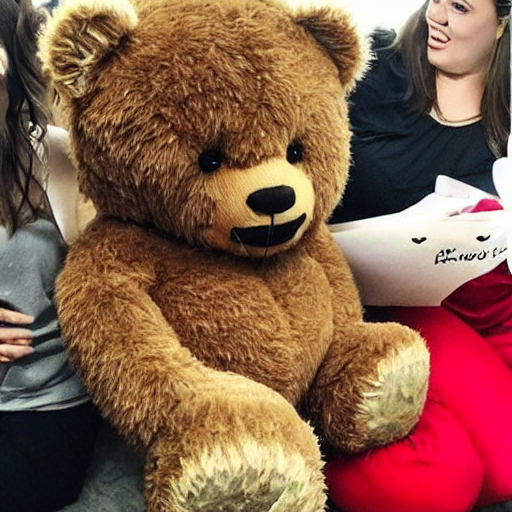

In [16]:
pipe(prompt).images[0]

In [ ]:
# Diffusion models begin from a set of random noise, and progressively move from this random noise to others
pipe(prompt, num_inference_steps = 32).images[0]

In [18]:
def image_grid(imgs, rows, cols):
    # Get the size of each image and make a new image of (cols * w, rows * h) size to fit all images inside
    w, h = imgs[0].size
    grid = Image.new('RGB', size = (cols * w, rows * h))
    # for the number of the image we have to try to find the spot that it will fit into
    for i, img in enumerate(imgs):
        grid.paste(img, box = (i % cols * w, i % rows * h))
    return grid

In [20]:
# Classifier free guidance
# is a method used to increase the adherence of the output image to the conditioning signal we used (the text prompt we gave it)
# The larger the guidance the more the model represents the specific text prompt - however larger values produce far less diversity within the images
# create an array of the prompts, based on the columns and then change them row wise based on the guidance_scale factor
# to change our classifier free guidance - creates two versions of the images - one with the prompt and one random image and takes the average of those two things
# guidance scale is the weighted average of these two images
rows, cols = 4, 4
prompts = [prompt] * cols
images = [concat(pipe(prompts, guidance_scale = g)).images for g in [1.1, 3, 7, 14]]
image_grid(images, rows, cols)

  0%|          | 0/50 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'images'

In [17]:
# Negative prompting
# instead of using a completely unconditioned generation we can use another prompt and scale the differences between that prompt and the condiitoned generation
# Negative prompting allows us to subtract these two images from eachother and reducing the importance of the negative prompt in our composition
# This will head us more towards the direction of the positive prompt
images = pipe(prompts, negative_prompt = "blue").images[0]

NameError: name 'prompts' is not defined

In [ ]:
# Image to image in stable diffusion we replace the initial denoising steps with the image with a certain amount of noise added to it - we can just pretend that the noisy image
# is exactly what our algorithm was initially coming up with
from diffusers import StableDiffusionImg2ImgPipeline
# this is very useful for using sketches and then passing in img2img followed by a prompt
images = pipei2i(prompt = prompt, num_images_per_prompt = 3, init_image = init_image, strength = 0.8, num_inference_steps = 50).images
# Take our pipei2i pipeline and then passing in out prompt - the amount of images we want generated for this prompt
# pass in the initial image sketch and a strength parameter
# strength dictates how close to the original sketch we want our image
# then we can obviously dictate how many inference steps we want

# we can then choose one of these images from our sketch and completely change it and combine multiple steps
chosen_img = images[2]
prompt = "Oil painting of wolf howling at the moon by Van Gogh"
images = pipei2i(prompt = prompt, init_image = chosen_img).images
image_grid = images, rows = 1, cols = 3)

In [ ]:
# Models can be fine tuned into working better - e.g you can pass it images of lots of pokemon to make it generate better pokemon
# a large dataset is required however, used an Image captioning model to generate captions for those images
# used that dataset of images caption pairs using the other image captioning model
# to fine tune the dataset

# Textual Inversion - allows us to create a new token and train embeddings 
# Give a meaning to certain images by freezing all other weights
# give a concept a name
# text_encoder.resize_token_embeddings(len(tokenizer))
# Texutal inversion has the embeddings frozen

In [ ]:
# Dreambooth - is a similar fine-tuning - takes an existing token and provides just a few images of the new subject, usually we use a very rarely used token, and fine tune the mode la few hundred steps to bring that token close to the images we provide.
# This is a regular process wehere all modules are unfrozen

In [ ]:
# Using a function that takes an images and calculates the probability that this classifies the correct images we want
# then we can go through all of the noisy images and denoise it by calculating the gradient of the probability of the function with respect to all of the pixels
# partial derivative of the loss with respect to each separate pixels
# so we can use the delta symbol - it is a vector of all of the possible combinations of derivatives of the loss wrt to the pixels
# del / nabla - is the gradient vector with an upside down triangle hence a jacobian

# we can use these gradient updates * a constant to the image to then update the images and which looks more like a handwritten digit and run this multiple times
# f.backward
# X.grad to see what the gradients are

# We can instead predict how much noise was actually added to the image instead of predicting how similar to the image it was in the first place
# by predicting hte amount of noise we can rather try to keep reducing the amount of noise - no noise (similar to image) noise (not similiar)

# we can predict the variance or hte actual noise itself as the neural net and therefore our loss function can be very simple
# MSE of the variance values
# our dataset is very simple since we are the ones that can generate this input - we can just add noise by a normal distribution adn thus we know the exact value
# and now we have a classifier function

# Neural network uses a Unet - this is the first component of stable diffusion
# takes a noisy image and outputs the noise
# if the unet is passed a latent which is hte compressed version using an encoder - we can subtract the noise from the noisy latents and give the actua llatents,
# then after taking the latent that has its noise removed via the unet we now have a large image

# we can compress an image to make it far more efficient using a convolutional layer of stride of 2 and then you double the number of channels
# then we remove a majority of the channels and they are compressed
# this compression can then get the image back after - if we use an inverse convolution
# then we create a loss function and this loss function would compare the output image with the input image
# we can then try to use MSE to minimise the error and thus maximise the compression and keeping the actual image
# This is how an autoencoder works
# the encoder of an autoencoder is now saved and far lower compression value 48x smaller than the initial size, as long as we  have access to the decoder
# we can now have a compression algorithm

# VAE saves a lot of compute power and a lot of resources that are not necessary

In [ ]:
# By passing the extra information such as what kind of digit it is we can more accurately predict and estimate noise better by taking advantage 
# of the fact that we know what the input is after it has been trained
# it will take hte noise as anything that it has not been trained for

# Unet - detects the noise from the noisy image passed into it (passed multiple parameters) gradients are a score function
# VAE - Takes an iamge and produces a compressed latent - then decodes the compressed latent back to what it was
#      - we can use this decoder to use less compute and make training faster
# CLIP Encoders - one-hot encoding of every sentence won't work, should take a sentence and return a vector of numbers to present an embedding
#         - take plenty of images which have an alt tag - the alt tag would describe this image and say what the image represents
#         - text encoder - 
#         - image encoder - 
#             - both take their respective inputs and they will both provide two vectors
#             - we can then take the dot product of the two outputs and we want to create a large dot product value
#             - we want to minimise the dot product between texts and the incorrect images and have the value as close to 0 as possible
#             - our loss function is the sum of the diagonals (correct texts and images)
#                 - and minimise the incorrect ones (contrasted loss) CL IP text encoder
                
#             - then texts representing similar pictures should provide a similar embedding
#             - a multimodal model based of a text encoder and an image encoder

# time steps can be used to add noise to our image - t is the time step that is added to the images taht we have
# beta is the standard deviation of noise that is being added whenever it is being trained
# pick an image, pick an amount of noise / t to use that amount of noise for each one (std of noise) - then we train the Unet
# to predict noise
# inference time - model now starts at the maximum beta or sigma value - then we want to reduce this noise so we take the prediction of the noise by a constant (e.g learning rate)
# then we subtract it from the pixels - by trying to remove the noise from the image (since the unet predict the noise for each image)

# By subtracting just part of the noise by using a constant to multiply by the gradient we slowly create new samples
# Diffusion sampler
# LR - momentum can be used for learning rate within the diffusion sampler
# if the variance of the learning rate changes we can use adam to optimise our learning rate
# momentum + adam (variance changing) - are used to optimise our model
# all diffusion models take the input pixels and the prompt along with taking t, the model will be better at removing the noise by telling it how much noise there is
# Perceptual loss instead of using MSE will help alot by improving out model
